In [2]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

In [3]:
url = 'https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'

data =  pd.read_csv(url)
data.head(3)

,A,S,E,O,R,T
0,adult,F,high,emp,small,train
1,young,M,high,emp,big,car
2,adult,M,uni,emp,big,other


In [4]:
model = BayesianNetwork(
    [
    ('A', 'E'),
    ('S', 'E'),
    ('E', 'O'),
    ('E', 'R'),
    ('O', 'T'),
    ('R', 'T')
    ]
    )

model.fit(data) # Only estimates p(x) as the frequency for each class
causal_markov_kernels = model.get_cpds()
causal_markov_kernels

[<TabularCPD representing P(A:3) at 0x7f9ae42f9910>,
 <TabularCPD representing P(E:2 | A:3, S:2) at 0x7f9ae4222dc0>,
 <TabularCPD representing P(S:2) at 0x7f9aa05eba30>,
 <TabularCPD representing P(O:2 | E:2) at 0x7f9aa05892b0>,
 <TabularCPD representing P(R:2 | E:2) at 0x7f9aa06845b0>,
 <TabularCPD representing P(T:3 | O:2, R:2) at 0x7f9aa06847f0>]

In [5]:
cmk = causal_markov_kernels[5]
print(cmk)

+----------+---------------------+---------------------+--------------------+----------+
| O        | O(emp)              | O(emp)              | O(self)            | O(self)  |
+----------+---------------------+---------------------+--------------------+----------+
| R        | R(big)              | R(small)            | R(big)             | R(small) |
+----------+---------------------+---------------------+--------------------+----------+
| T(car)   | 0.7034313725490197  | 0.524390243902439   | 0.4444444444444444 | 1.0      |
+----------+---------------------+---------------------+--------------------+----------+
| T(other) | 0.13480392156862744 | 0.08536585365853659 | 0.3333333333333333 | 0.0      |
+----------+---------------------+---------------------+--------------------+----------+
| T(train) | 0.16176470588235295 | 0.3902439024390244  | 0.2222222222222222 | 0.0      |
+----------+---------------------+---------------------+--------------------+----------+


In [6]:
estimator = BayesianEstimator(model, data)

model.fit(data,
          estimator=BayesianEstimator,
          prior_type="dirichlet",
          pseudo_counts=1
         )

causal_markov_kernels = model.get_cpds()
cmk_Prior = causal_markov_kernels[5]

In [7]:
print(cmk_Prior)

+----------+--------------------+---------------------+--------------------+----------+
| O        | O(emp)             | O(emp)              | O(self)            | O(self)  |
+----------+--------------------+---------------------+--------------------+----------+
| R        | R(big)             | R(small)            | R(big)             | R(small) |
+----------+--------------------+---------------------+--------------------+----------+
| T(car)   | 0.7007299270072993 | 0.5176470588235295  | 0.4166666666666667 | 0.5      |
+----------+--------------------+---------------------+--------------------+----------+
| T(other) | 0.1362530413625304 | 0.09411764705882353 | 0.3333333333333333 | 0.25     |
+----------+--------------------+---------------------+--------------------+----------+
| T(train) | 0.1630170316301703 | 0.38823529411764707 | 0.25               | 0.25     |
+----------+--------------------+---------------------+--------------------+----------+


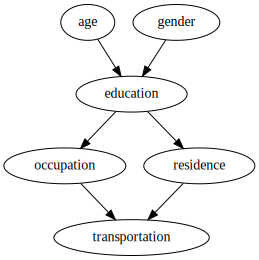

In [10]:
import torch
import pyro
from pyro.distributions import Categorical
A_alias = ['young', 'adult', 'old']
S_alias = ['M', 'F']
E_alias = ['high', 'uni']
O_alias = ['emp', 'self']
R_alias = ['small', 'big']
T_alias = ['car', 'train', 'other']

A_prob = torch.tensor([0.3,0.5,0.2])
S_prob = torch.tensor([0.6,0.4])
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]], # 3X2
                       [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],
                       [[0.58,0.24,0.18], [0.7,0.21,0.09]]])

def model():
    A = pyro.sample("age", Categorical(probs=A_prob)) 
    S = pyro.sample("gender", Categorical(probs=S_prob)) 
    E = pyro.sample("education", Categorical(probs=E_prob[S][A])) 
    O = pyro.sample("occupation", Categorical(probs=O_prob[E]))
    R = pyro.sample("residence", Categorical(probs=R_prob[E]))
    T = pyro.sample("transportation", Categorical(probs=T_prob[R][O])) 
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T} 

pyro.render_model(model)